In [18]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas


# Regression problem 
## ANFIS - Adaptative Neuro Fuzzy Inference Systems

This problem follows the same format as other fuzzy set analysis. The data is uploaded and divided into 20% training and 80% testing,followed by standardizing the features which allows for an unbiased analysis(the dimension of the features does not matter). 

In [19]:
# CHOOSE DATASET

# Binary classification dataset
diabetes = datasets.load_diabetes(as_frame=True)

X = diabetes.data.values
y = diabetes.target.values 
X.shape


(442, 10)

In [20]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [21]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


To initialize the training fase the clusters(n) and the fuzzifier(m) value are defined. The number of clusters represents the number of fuzzy rules, and m is the fuzzinesss parameter. The centers are the rule consequents. From previous analysis changing these 2 values did not improve the results of acuracy, and so these will not be tuned.

In [22]:
 # Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [23]:
centers.shape

(2, 11)

In [24]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.8556199828116134


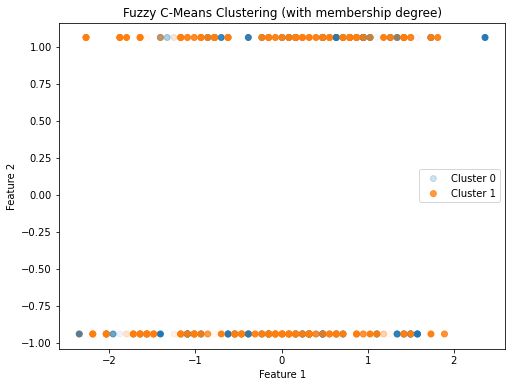

In [25]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

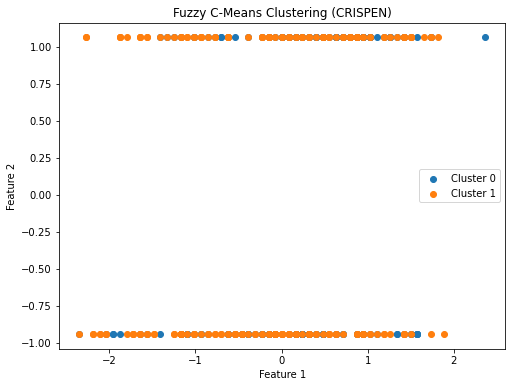

In [26]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

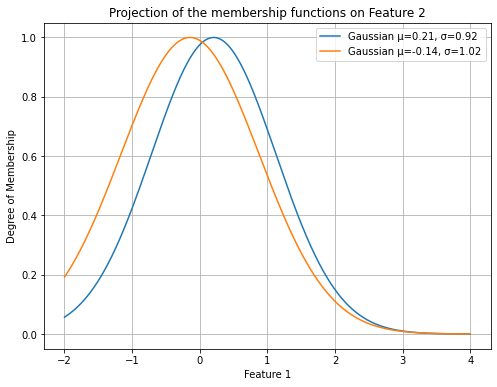

In [27]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

The Gaussian Membership Functions works as the guide to wich cluster each data should belong to. 

In [28]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



The Class above defines the TSK model in 3 big steps.The antecedents are defined usinfg the fuzzifier gaussian membership function, next the consequents are created as a linear function of the inputs and finally the inferance.

In [29]:
# Least Squares Solver for Consequents (TSK)
#to get the optimal a and b already optimal
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [34]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

The Classical ANFIS model has 5 layers:
- Premise Parameters
- Rule firing strengths
- Normalized firing strengths
- Consequent parameters
- Single node overall output
The code bellow follows exactly this, with a 2 step of the antecedents and of the consequents.


In [35]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [36]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [37]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/2256170614.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/2256170614.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/2256170614.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xte = torch.tensor(Xte, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/2256170614.py:7: UserWar

The model is then trained with the hybrid training class that was implemented, which is the only coding diferrence between this and the TKS.

In [38]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))


tensor(2683.3757, grad_fn=<MseLossBackward0>)
tensor(2682.0750, grad_fn=<MseLossBackward0>)
tensor(2680.8552, grad_fn=<MseLossBackward0>)
tensor(2679.6592, grad_fn=<MseLossBackward0>)
tensor(2678.5007, grad_fn=<MseLossBackward0>)
tensor(2677.3875, grad_fn=<MseLossBackward0>)
tensor(2676.3042, grad_fn=<MseLossBackward0>)
tensor(2675.2214, grad_fn=<MseLossBackward0>)
tensor(2674.1150, grad_fn=<MseLossBackward0>)
tensor(2673.0176, grad_fn=<MseLossBackward0>)
tensor(2671.9224, grad_fn=<MseLossBackward0>)
tensor(2670.8342, grad_fn=<MseLossBackward0>)
tensor(2669.7590, grad_fn=<MseLossBackward0>)
tensor(2668.6704, grad_fn=<MseLossBackward0>)
tensor(2667.5854, grad_fn=<MseLossBackward0>)
tensor(2666.4961, grad_fn=<MseLossBackward0>)
tensor(2665.4150, grad_fn=<MseLossBackward0>)
tensor(2664.3586, grad_fn=<MseLossBackward0>)
tensor(2663.3115, grad_fn=<MseLossBackward0>)
tensor(2662.2681, grad_fn=<MseLossBackward0>)
tensor(2658.7737, grad_fn=<MseLossBackward0>)
tensor(2657.4956, grad_fn=<MseLoss

In [39]:
y_pred, _, _=model(Xte)
#performance metric for classification
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2658.492919921875


As expected the results once again are far from good, The 2 clusters dont allow fro a complex analysis of all the features involved. 

## Neural Networks

The following class is a standard feed forward Neural Network, with the ReLU activation function, dropout and a single output layer.

In [40]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

When creating this model the following hyperparameters are chosen and then fine tuned as an atempt to create a better MSE.
- The num_epochs defines the number of full passesover the traiing set.
- lr is the learning rate at wich the optimizer updates the weights
- dropout randomly drops out 10% of hidden units to ensure that the data iks not overfit
- batch_size is the number os damples used to compute one gradient update


In [94]:
num_epochs=100
lr=0.0005
dropout=0.1
batch_size=64

In [95]:
#Xtr = torch.tensor(Xtr, dtype=torch.float32)
#ytr = torch.tensor(ytr, dtype=torch.float32)
#Xte = torch.tensor(Xte, dtype=torch.float32)
#yte = torch.tensor(yte, dtype=torch.float32)
Xtr = Xtr.clone().detach().float()
ytr = ytr.clone().detach().float()
Xte = Xte.clone().detach().float()
yte = yte.clone().detach().float()

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [96]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)#you can use another optimizer from the pytorch libr<ary

In [97]:
# Training loop
for epoch in range(num_epochs):
    model.train()#if you want to put model.evalit wont change the NN
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")#how much am i loosing

Epoch [1/100], Loss: 30286.9349
Epoch [2/100], Loss: 29687.7480
Epoch [3/100], Loss: 29602.2676
Epoch [4/100], Loss: 29530.4912
Epoch [5/100], Loss: 29709.5960
Epoch [6/100], Loss: 29357.3372
Epoch [7/100], Loss: 29101.6016
Epoch [8/100], Loss: 28984.9844
Epoch [9/100], Loss: 28566.5557
Epoch [10/100], Loss: 27337.9606
Epoch [11/100], Loss: 26801.2575
Epoch [12/100], Loss: 24339.2214
Epoch [13/100], Loss: 22271.5755
Epoch [14/100], Loss: 19309.1751
Epoch [15/100], Loss: 15456.2622
Epoch [16/100], Loss: 11355.1061
Epoch [17/100], Loss: 8604.9583
Epoch [18/100], Loss: 6442.2880
Epoch [19/100], Loss: 5701.7699
Epoch [20/100], Loss: 5884.4884
Epoch [21/100], Loss: 5255.0184
Epoch [22/100], Loss: 4968.0422
Epoch [23/100], Loss: 4595.2240
Epoch [24/100], Loss: 4481.0530
Epoch [25/100], Loss: 4524.5169
Epoch [26/100], Loss: 4193.7067
Epoch [27/100], Loss: 4317.2848
Epoch [28/100], Loss: 3830.4580
Epoch [29/100], Loss: 4085.9329
Epoch [30/100], Loss: 3996.4889
Epoch [31/100], Loss: 4046.4784
E

In [98]:
y_pred=model(Xte)
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2963.9765625


Since the MSE is very high, 2 problems can occure or overfitting or underfitting(slow learning) after altering the hyperparameters to obtain better results none obtained a lower MSE than the original values. In the case of underfitting the learning rate was increased and the eppochs duplicated this led to a MSE 1000 times higher.Next only one these was altered and still the MSE was higher than the original. In the Overfitting case no changes helped lowering the learning rate and the number of epochs and even the batch size all led worse results. This allows for a conclusion that the probelem is the scope, and not the model.


# Clasification problem 
## ANFIS
This problem was constructed in the exact same way as the regression, only the data uploading method is diferent.

In [100]:
# CHOOSE DATASET
from sklearn.datasets import fetch_openml
# Regression dataset
diabetes = datasets.fetch_openml("diabetes",version=1, as_frame=True) 

X = diabetes.data.values
y = diabetes.target.values 
X.shape


(768, 8)

In [101]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [102]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [103]:
 # Number of clusters 
n_clusters = 2
m=2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytr_enc = le.fit_transform(ytr)   # numeric 0/1
yte_enc = le.transform(yte)
# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr_enc.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [104]:
centers.shape

(2, 9)

In [105]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.5000056457580432


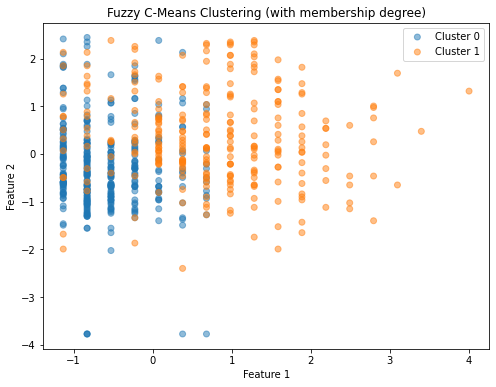

In [106]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

Fuzzy partition coefficient (FPC): 0.5000056457580432


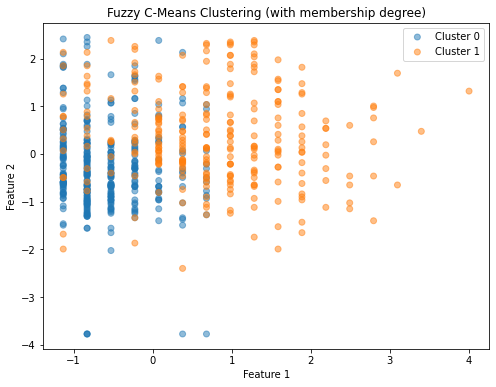

In [107]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

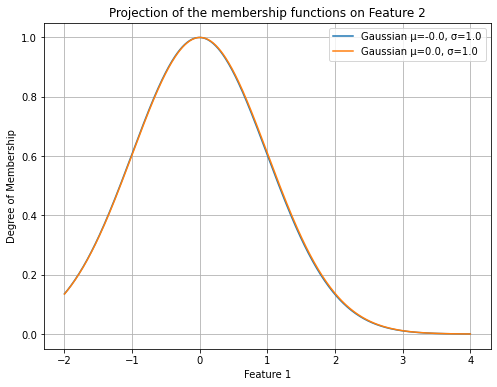

In [108]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [110]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [111]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr_enc, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte_enc, dtype=torch.float32)


In [112]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))


tensor(0.1490, grad_fn=<MseLossBackward0>)
tensor(0.1711, grad_fn=<MseLossBackward0>)
tensor(0.1480, grad_fn=<MseLossBackward0>)
tensor(0.1520, grad_fn=<MseLossBackward0>)
tensor(0.1601, grad_fn=<MseLossBackward0>)
tensor(0.1555, grad_fn=<MseLossBackward0>)
tensor(0.1475, grad_fn=<MseLossBackward0>)
tensor(0.1455, grad_fn=<MseLossBackward0>)
tensor(0.1496, grad_fn=<MseLossBackward0>)
tensor(0.1528, grad_fn=<MseLossBackward0>)
tensor(0.1511, grad_fn=<MseLossBackward0>)
tensor(0.1470, grad_fn=<MseLossBackward0>)
tensor(0.1449, grad_fn=<MseLossBackward0>)
tensor(0.1462, grad_fn=<MseLossBackward0>)
tensor(0.1486, grad_fn=<MseLossBackward0>)
tensor(0.1490, grad_fn=<MseLossBackward0>)
tensor(0.1473, grad_fn=<MseLossBackward0>)
tensor(0.1454, grad_fn=<MseLossBackward0>)
tensor(0.1450, grad_fn=<MseLossBackward0>)
tensor(0.1460, grad_fn=<MseLossBackward0>)
tensor(0.1436, grad_fn=<MseLossBackward0>)
tensor(0.1617, grad_fn=<MseLossBackward0>)
tensor(0.1445, grad_fn=<MseLossBackward0>)
tensor(0.14

In [113]:
y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#performance metric for regression
#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7532467532467533


The results for this model are much more promising near to 0,as expected. The choice of clusters and the fuzzifier where corrrect for this data.

## Neural Network
This Model is also the same as the previous one and the data set the same.

In [120]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [165]:
num_epochs=200
lr=0.005
dropout=0.05
batch_size=64

In [166]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/3341141645.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/3341141645.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/3341141645.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xte = torch.tensor(Xte, dtype=torch.float32)
C:\Users\Aliya\AppData\Local\Temp/ipykernel_4592/3341141645.py:4: UserWar

In [167]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)#you can use another optimizer from the pytorch libr<ary

In [168]:
# Training loop
for epoch in range(num_epochs):
    model.train()#if you want to put model.evalit wont change the NN
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")#how much am i loosing

Epoch [1/200], Loss: 0.2081
Epoch [2/200], Loss: 0.1761
Epoch [3/200], Loss: 0.1596
Epoch [4/200], Loss: 0.1466
Epoch [5/200], Loss: 0.1443
Epoch [6/200], Loss: 0.1433
Epoch [7/200], Loss: 0.1361
Epoch [8/200], Loss: 0.1331
Epoch [9/200], Loss: 0.1268
Epoch [10/200], Loss: 0.1265
Epoch [11/200], Loss: 0.1208
Epoch [12/200], Loss: 0.1162
Epoch [13/200], Loss: 0.1178
Epoch [14/200], Loss: 0.1138
Epoch [15/200], Loss: 0.1140
Epoch [16/200], Loss: 0.1090
Epoch [17/200], Loss: 0.1030
Epoch [18/200], Loss: 0.1007
Epoch [19/200], Loss: 0.0980
Epoch [20/200], Loss: 0.0971
Epoch [21/200], Loss: 0.0887
Epoch [22/200], Loss: 0.0890
Epoch [23/200], Loss: 0.0818
Epoch [24/200], Loss: 0.0864
Epoch [25/200], Loss: 0.0806
Epoch [26/200], Loss: 0.0811
Epoch [27/200], Loss: 0.0778
Epoch [28/200], Loss: 0.0810
Epoch [29/200], Loss: 0.0733
Epoch [30/200], Loss: 0.0720
Epoch [31/200], Loss: 0.0770
Epoch [32/200], Loss: 0.0670
Epoch [33/200], Loss: 0.0593
Epoch [34/200], Loss: 0.0586
Epoch [35/200], Loss: 0

In [173]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.6688311688311688


| Hyperparameter / Metric | Attempt 1 | Attempt 2 | Attempt 3 | Attempt 4 | Attempt 5 | Attempt 6|Attempt 7|
|:------------------------|----------:|----------:|----------:|----------:|----------:|----------|---------|
| num_epochs              | 100       |200        | 200       |100        |200        |200       | 200     |
| lr                      |0.0005     |0.0005     |0.001      |0.005      |0.005      |0.005     | 0.005   |
| dropout                 |0.1        |0.1        |0.1        |0.1        |0.1        |0.05      |0.05     |
| batch_size              |64         |64         |64         |64         |64         |64        |32       |
| MSE (validation)        |0.7077     |0.72       |0.78       |0.701      |0.688      |0.6623    |0.72     |


To conclude the classification of this data set shows much better results. From all the attemptsnthe best is attempt 5 which is alterations for an underfitting problem, the learning rate, the number of epochs are increased. 

In [174]:
https://github.com/aliyamay/SistemasInteligentes_103293

SyntaxError: invalid syntax (Temp/ipykernel_4592/2937723376.py, line 1)